# Electricity Dataset

https://paperswithcode.com/dataset/electricity

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

In [26]:
# Load data from data/household_power_consumption.txt:
# Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
# 16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000

# /var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/4231314181.py:5: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
#   df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
# /var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/4231314181.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
#   df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
# , dtype={'Global_active_power': np.float64}
df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
df = df[['ds', 'Global_active_power']]

/var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/1754546841.py:10: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
/var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/1754546841.py:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})


,ds,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
5,2006-12-16 17:29:00,3.520
6,2006-12-16 17:30:00,3.702
7,2006-12-16 17:31:00,3.700
8,2006-12-16 17:32:00,3.668
9,2006-12-16 17:33:00,3.662


In [28]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

In [37]:
# count NA values
df.isna().sum() / len(df)

ds                     0.0
Global_active_power    0.0
dtype: float64

In [36]:
# fill NA values with the previous value
df = df.ffill()

## Load time series data

<TimeSeries (DataArray) (ds: 2075259, component: 1, sample: 1)> Size: 17MB
array([[[4.216]],

       [[5.36 ]],

       [[5.374]],

       ...,

       [[0.938]],

       [[0.934]],

       [[0.932]]])
Coordinates:
  * ds         (ds) datetime64[ns] 17MB 2006-12-16T17:24:00 ... 2010-11-26T21...
  * component  (component) object 8B 'Global_active_power'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [44]:
series = TimeSeries.from_dataframe(df, time_col='ds', value_cols='Global_active_power', fill_missing_dates=True, freq=None)
series = series.slice_n_points_before(series.end_time(), 30*24*60)

<Axes: xlabel='ds'>

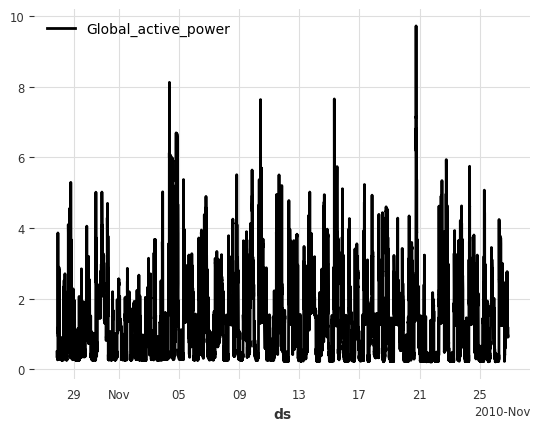

In [45]:
series.plot()

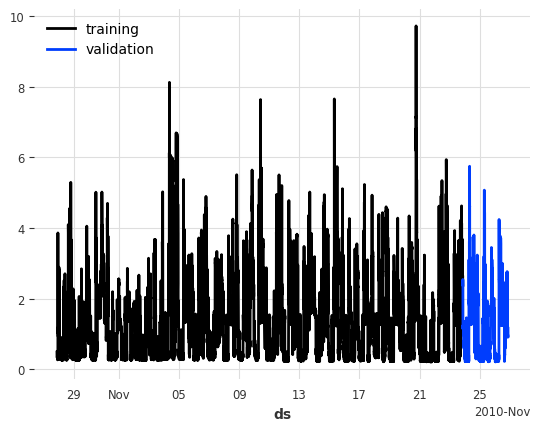

In [47]:
train, val = series.split_after(0.9)
train.plot(label="training")
val.plot(label="validation")

to_predict = len(val)

## Baseline Model

<Axes: xlabel='ds'>

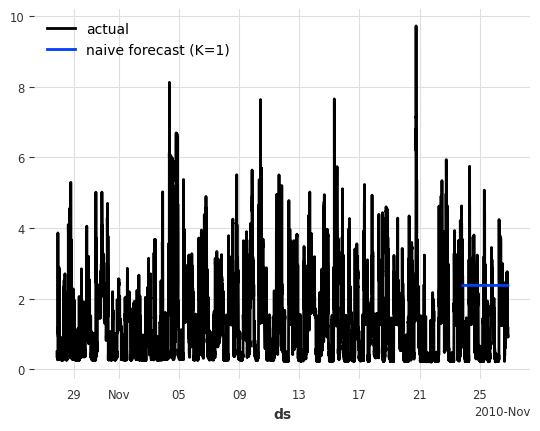

In [48]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(to_predict)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


<Axes: xlabel='ds'>

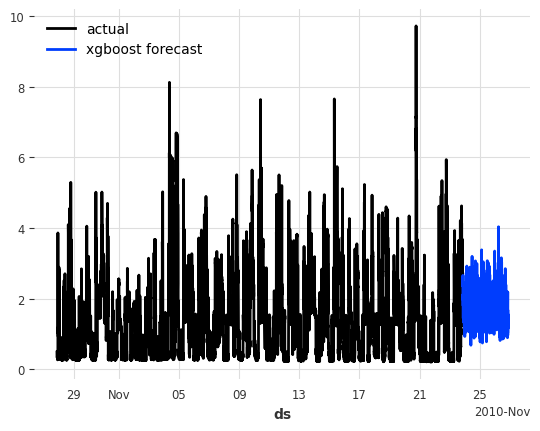

In [50]:
# TODO: Fix this model
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(
    lags=12,
    output_chunk_length=100,
)

xgb_model.fit(target, verbose=True)

xgb_forecast = xgb_model.predict(to_predict)


<Axes: xlabel='ds'>

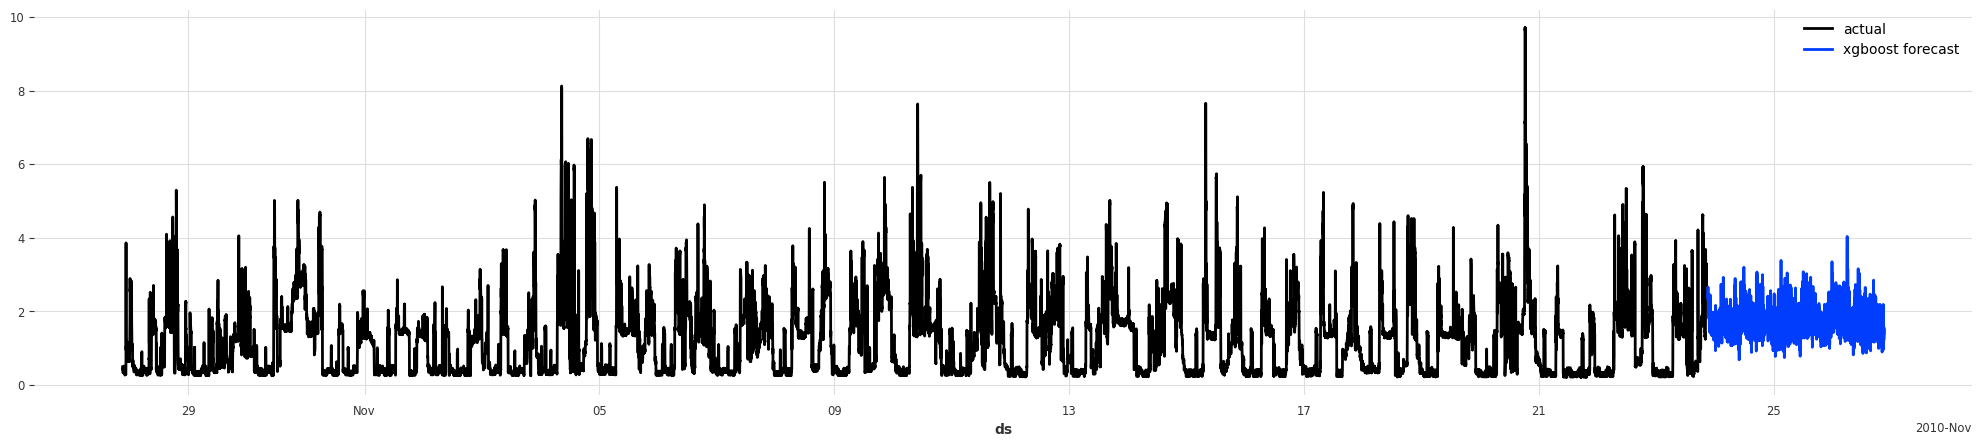

In [56]:
plt.figure(figsize=(25,5))
train.plot(label="actual")
xgb_forecast.plot(label="xgboost forecast")